- authors: Macrina Lobo, Eric Kernfeld

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy, os, sys, shutil, importlib, glob
from tqdm.notebook import tqdm
from celloracle import motif_analysis as ma
#os.chdir("/Users/erickernfeld/Dropbox/pharynx_celloracle")

In [9]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [10]:
base_path = "/Users/LoboM/Dropbox/sharedUMass_Macrina_Rene/celloracle_pharynx_2021_v2_hyphen_cisbp2/"

In [11]:
# Load all peaks
peaks_as_df = pd.read_csv(base_path + "/input_files/E11_E12_peaks_all.txt", index_col=0)


In [12]:
peaks_as_df['peakType'].value_counts()

Intronic    126198
Distal      104325
Promoter     25250
Exonic       14437
Name: peakType, dtype: int64

In [13]:
def concatenate_one(row):
    return '_'.join((row[1]['seqnames'], str(row[1]['start']), str(row[1]['end'])))
peaks = [concatenate_one(row) for row in peaks_as_df.iterrows()]
#peaks

In [14]:
len(peaks)

270210

In [15]:
loops = pd.read_csv(base_path + "/input_files/coaccessibility_tuned.txt", index_col=0)

In [16]:
# Load cicero results
#loops = pd.read_csv(base_path + "/input_for_cell_oracle/coaccessibility_E11_E12.txt", index_col=0)
loops['peak1'] = [peaks[i-1] for i in loops['queryHits']] 
loops['peak2'] = [peaks[i-1] for i in loops['subjectHits']]
loops = loops[['peak1', 'peak2', 'correlation']]
loops.columns = ['Peak1', 'Peak2', 'coaccess']
def get_start(interval_as_string):
    return int(interval_as_string.split('_')[1])
#get_start(loops.loc[164417,'Peak1'])
loops['distance'] = [get_start(loops.loc[i,'Peak1']) - get_start(loops.loc[i,'Peak2']) for i in range(1,len(loops.index)+1)]

In [17]:
loops

,Peak1,Peak2,coaccess,distance
1,chr1_3433763_3434263,chr1_3448145_3448645,0.676687,-14382
2,chr1_3448145_3448645,chr1_3433763_3434263,0.676687,14382
3,chr1_3912579_3913079,chr1_3913598_3914098,0.602085,-1019
4,chr1_3913598_3914098,chr1_3912579_3913079,0.602085,1019
5,chr1_4613993_4614493,chr1_4671602_4672102,0.604138,-57609
...,...,...,...,...
164413,chrX_169922501_169923001,chrX_169940527_169941027,0.663782,-18026
164414,chrX_169923400_169923900,chrX_169804131_169804631,0.716358,119269
164415,chrX_169927973_169928473,chrX_169928677_169929177,0.504237,-704
164416,chrX_169928677_169929177,chrX_169927973_169928473,0.504237,704


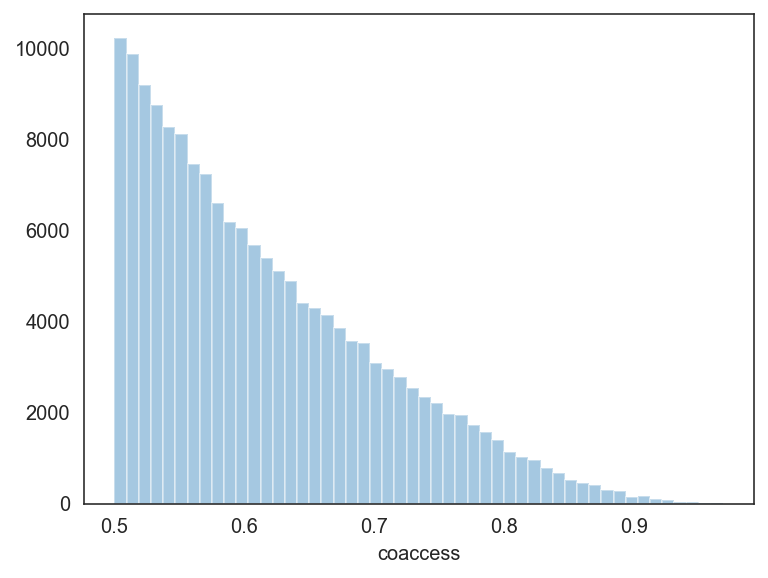

In [18]:
ax = sns.distplot( a = loops.coaccess, kde=False )

In [20]:
# use Homer to get TSS info for peaks and pick up peaks intersecting with the TSS
tss_annotated = ma.get_tss_info(peak_str_list=peaks, ref_genome='mm10') 
tss_annotated.tail()

que bed peaks: 270210
tss peaks in que: 29382


,chr,start,end,gene_short_name,strand
29377,chr12,100899012,100899512,Gpr68,-
29378,chr4,129490361,129490861,Fam229a,-
29379,chr4,129490963,129491463,Fam229a,-
29380,chr4,129491511,129492011,Fam229a,-
29381,chr17,24473668,24474168,Bricd5,+


In [21]:
len(peaks)

270210

(35418, 3)


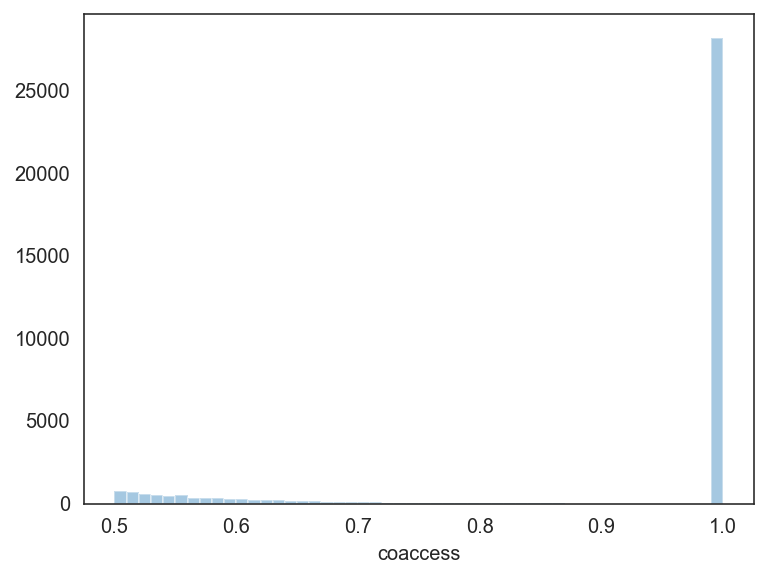

In [23]:
# find all peaks which are coaccessibile with a TSS(or TSS-intersecting) peak
integrated = ma.integrate_tss_peak_with_cicero(tss_peak=tss_annotated, 
                                               cicero_connections=loops)
print(integrated.shape)
ax = sns.distplot( a = integrated.coaccess , kde=False)

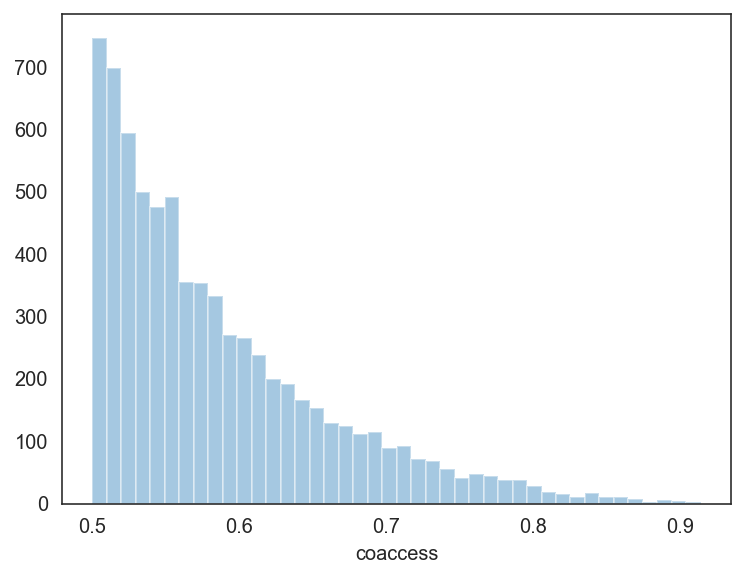

In [24]:
ax = sns.distplot( a = integrated.coaccess[integrated.coaccess<1] , kde=False)

In [25]:
loops.shape

(164417, 4)

In [26]:
integrated

,peak_id,gene_short_name,coaccess
0,chr10_100015544_100016044,Kitl,1.0
1,chr10_100487191_100487691,Tmtc3,1.0
2,chr10_100487769_100488269,Tmtc3,1.0
3,chr10_100589009_100589509,4930430F08Rik,1.0
4,chr10_100741990_100742490,Gm35722,1.0
...,...,...,...
35413,chrX_99471074_99471574,Pja1,1.0
35414,chrX_99820093_99820593,Tmem28,1.0
35415,chrX_99820602_99821102,Tmem28,1.0
35416,chrX_99821117_99821617,Tmem28,1.0


In [36]:
# Filter peaks by the 98th percentile of coaccessibility, calculated before TSS integration.
#cutoff = np.quantile(loops.coaccess, 0.98)
#print(cutoff)
cutoff =  0.45 # keep all peaks
peak2 = integrated[integrated.coaccess >= cutoff]
peak2 = peak2[["peak_id", "gene_short_name"]].reset_index(drop=True)

In [37]:
peak2

,peak_id,gene_short_name
0,chr10_100015544_100016044,Kitl
1,chr10_100487191_100487691,Tmtc3
2,chr10_100487769_100488269,Tmtc3
3,chr10_100589009_100589509,4930430F08Rik
4,chr10_100741990_100742490,Gm35722
...,...,...
35413,chrX_99471074_99471574,Pja1
35414,chrX_99820093_99820593,Tmem28
35415,chrX_99820602_99821102,Tmem28
35416,chrX_99821117_99821617,Tmem28


In [38]:
peak_all = integrated[["peak_id", "gene_short_name"]].reset_index(drop=True)

In [39]:
save_dir = "../intermediate_results"
#import os
#os.mkdir(save_dir)
peak2.to_csv(save_dir + "/peaks_plus_loops_corr_45.csv") # from gimme directory